XGBoost
===

**Autor:** Matheus Pereira Velloso da Silveira e Mateus de Jesus Mendes

# Introdução

## Fundamentação Teórica

###  XGBoost

O Extreme Gradient Boosting (XGBoost) é um modelo que utiliza decision trees em sequência. Enquanto a Random Forest usa várias árvores em bagging, ou seja, treina todas as árvores de forma independente e combina suas previsões ao final, o boosting utiliza as árvores em sequência, em que as árvores são usadas para prever o erro de modelos anteriores. Isso lembra o tema do projeto, Delta Learning, porém com no boosting sendo feito sucessivas vezes.

Em Machine Learning, a regressão linear é um dos modelos mais simples de previsão de dados. Porém, ela pode sofrer com *underfitting* e *overfitting*. O que acontece é que a regressão linear faz previsões calculando um polinômio para tentar representar o resultado, porém, para representar com grande acurácia os dados de treino, é necessário um polinômio de grau alto, que pode gerar resultados melhores para os dados de treino, mas piores para os demais, ou seja *overfiting* (sobreajuste). Veja na imagem abaixo:
<div align="center">
    <img src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/bb/4e/6-1_sequential-ensemble-learning_boosting.component.l.ts=1739197330108.png/content/adobe-cms/br/pt/think/topics/xgboost/jcr:content/root/table_of_contents/body-article-8/image" alt="Fern vs Ehre" width="800">
</div>

https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/bb/4e/6-1_sequential-ensemble-learning_boosting.component.l.ts=1739197330108.png/content/adobe-cms/br/pt/think/topics/xgboost/jcr:content/root/table_of_contents/body-article-8/image

#### Matemática do XGBoost

Primeiramente, um modelo simples prevê um resultado $y_i$ para os inputs $x_i$, utilizando um algoritmo, como para o modelo linear:

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2^2 + \theta_3 x_3^3 + \theta_4 x_4^4...$$

$$\hat{y} = \sum_{j} \theta_jx_{ij}$$

Além disso, para o treino do modelo teremos a denominada objective function, que mede o quão bem o modelo se comporta. 

$$ obj(\theta) = L(\theta) + \Omega(\theta)

Essa função é tal que L é a training loss function, que mede o quão bom são os resultados previstos em comparação com o que deveria prever. Um exemplo muito usado é o MSE:

$$L(\theta) = \sum_{i} (y_i - \hat{y}_i)^2$$

Enquanto $\Omega$ é o termo de regularização, que controla a complexidade do modelo, evitando o Overfitting.

Agora, sobre as Decision Trees, o XGBoost é um ensemble delas. O ensemble de árvores de regressão e classificação (CART) difere das Decision Trees ao introduzir um valor real para cada folha, o que será usado para a otimização. Veja a imagem como exemplo:

<div align="center">
    <img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png" alt="Fern vs Ehre" width="800">
</div>

https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png

Veja que as duas árvores são usadas em conjunto somadas para obter a previsão, ou seja:

$$
\hat{y}_i = \sum_{k=1}^{K} f_k(x_i), f_k \in F
$$

Com K o número de árvores, F todo o espaço de CARTs e $f_k$ a função nesse espaço. Dessa forma, a função objetiva é definida como:

$$
obj(\theta) = \sum_{i}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \omega(f_k)
$$

Com $\omega(f_k)$ a complexidade da árvore $f_k$.

Agora, enfim, chegando especificamente ao boosting, definimos nossa função objetivo a ser otimizada:

$$
obj = \sum_{i}^{n} l(y_i, \hat{y}_i^{(t)}) + \sum_{k=1}^{t} \omega(f_k)
$$

Em que t é o número de árvores no sensemble. Como dito anteriormente, cada passo utilizará uma só arvore.

Para as árvores, não conseguimos fazer o cálculo de $f_k$ diretamente para todas, assim, calcularemos ela passo a passo.

$$
\hat{y_i}^{0} = 0
$$
$$
\hat{y_i}^{1} = f_1(x_i) = \hat{y_i}^{0} + f_1(x_i)
$$
$$
\dots
$$
$$
\hat{y_i}^{t} \sum_{k=1}^{t} f_k(x_i) = \hat{y_i}^{t-1} + f_t(x_i)
$$

Reescrevendo nossa função objetivo:

$$
obj^t = \sum_{i}^{n} l(y_i, \hat{y_i}^{t-1} + f_t(x_i)) + \sum_{k=1}^{t} \omega(f_k) + C
$$

Essa é a fórmula geral. O XGBoost nos propõe usar o MSE, então vejamos o que acontecerá:

$$
obj^t = \sum_{i}^{n} l(y_i - (\hat{y_i}^{t-1} + f_t(x_i)))^2 + \sum_{k=1}^{t} \omega(f_k) + C
$$

Fazendo a expansão, os termos até ordem 1 são significativos para a loss function, então reorganizando os termos:

$$
obj^t = \sum_{i}^{n} l(2(\hat{y}_i^{t-1}-y_i)f_t(x_i) + f_t(x_i)^2) + \omega(f_t) + C
$$

Nosso objetivo será minimizar essa função. Porém, não é trivial obter isso só usando gradiente. Dessa forma, fazemos algumas adaptações, cortamos as constantes, e obtemos:

$$
obj^t = \sum_{i}^{n} [g_if_t(x_i) + \frac{1}{2}h_if_t^2(x_i)] + \omega(f_t)
$$
$$
g_i = \partial_{\hat{y_i}^{(t-1)}}l(y_i, \hat{y_i}^{t-1})
$$
$$
h_i = \partial^{2}_{\hat{y_i}^{(t-1)}}l(y_i, \hat{y_i}^{t-1})
$$

Essa é a forma final de escrever a loss function, que é vantajosa por só depender de g e de h.

Explorando agora a parte de complexidade, o XGBoost define a função de complexidade como:

$$
\omega(f) = \gamma\Tau + \frac{1}{2}\lambda\sum_{j=1}^{\Tau}w_j^{2}
$$

Em que w é o valor de score nas folhas, $\Tau$ o número de folha e q, que será usado posteriormente, uma função que associa os dados a sua folha.

Finalmente, substituindo na função objetivo, obtemos o termo que tentaremos minimizar. Mais operações matemáticas podem ser feitas para simplificar a função, mas elas fogem ao escopo desta explicação.

$$
obj^t = \sum_{i}^{n} [g_if_t(x_i) + \frac{1}{2}h_if_t^2(x_i)] + \gamma\Tau + \frac{1}{2}\lambda\sum_{j=1}^{\Tau}\omega_j^{2}
$$

Com as simplificações feitas, nós teremos como resultado:

$$
obj^{*} = -\frac{1}{2}\sum_{i}^{\Tau}\frac{G_j^{2}}{H_j + \lambda} + \gamma\Tau
$$
$$
I_j = {i|q(x_i) = j}
$$
$$
G_j = \sum_{i\in I_j} g_i
$$
$$
H_j = \sum_{i\in I_j} g_i
$$

Veja na imagem uma rápida exemplificação:

<div align="center">
    <img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/struct_score.png" alt="Fern vs Ehre" width="800">
</div>

https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/struct_score.png

# Metodologia

### Importações

In [26]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector
from optuna import create_study, load_study
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned

import shap

### Definições Globais

Definições de parâmetros globais usados ao longo desse *Jupyter Notebook*, a fim de assegurar clareza metodológica e reprodutibilidade:

In [3]:
RANDOM_SEED = 88
PATH = '../../dataset_processing/xtb_dataset.csv'
TRAIN_SIZE = 0.8
STUDY_NAME = 'xgboost'

### Leitura dos Dados

Leitura do *dataset*:

In [20]:
df = pd.read_csv(PATH)

X = df.drop(columns=['Delta'])
y = df['Delta']

### Pré-processamento dos Dados

Divisão do *dataset* em subconjuntos de dados de treino e teste, considerando as *features* e o *target*:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

### Treino & Otimização de Hiperparâmetros

Função para gerar as combinações de parâmetros a serem usados pelo `optuna`:

In [7]:
def suggest_xgb_params(trial):
    params = {}

    params['booster'] = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    params['objective'] = 'reg:squarederror'
    params['verbosity'] = 0
    params['random_state'] = trial.number
    params['n_jobs'] = 1

    params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)

    params['n_estimators'] = trial.suggest_int('n_estimators', 100, 3000)  # usar early stopping/pruner

    params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
    params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.4, 1.0)
    params['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', 0.4, 1.0)
    params['colsample_bynode'] = trial.suggest_float('colsample_bynode', 0.4, 1.0)

    params['min_child_weight'] = trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True)
    params['gamma'] = trial.suggest_float('gamma', 1e-8, 10.0, log=True)

    params['reg_alpha'] = trial.suggest_float('reg_alpha', 1e-8, 100.0, log=True)
    params['reg_lambda'] = trial.suggest_float('reg_lambda', 1e-8, 100.0, log=True)

    params['max_delta_step'] = trial.suggest_int('max_delta_step', 0, 10)

    params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if params['grow_policy'] == 'depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 3, 12)
        # max_leaves is ignored for depthwise, ensure not set (or set large)
        params['max_leaves'] = 0
    else:  # lossguide
        params['max_depth'] = 0  # ignored by lossguide
        params['max_leaves'] = trial.suggest_int('max_leaves', 8, 1024)

    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_float('rate_drop', 0.0, 0.3)
        params['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.3)
    else:
        # ensure DART params not present for gbtree (optional: they are simply ignored)
        params['sample_type'] = 'uniform'
        params['normalize_type'] = 'tree'
        params['rate_drop'] = 0.0
        params['skip_drop'] = 0.0

    return params

Função para instanciar o modelo com todos os hiperparâmetros e tratamentos a serem usados pelo `optuna`:

In [ ]:
def inst_xgboost(trial):
    params = suggest_xgb_params(trial)

    # Métodos que fazem sentido para XGBoost
    pre_processing = trial.suggest_categorical(
        "pre_processing",
        ["none", "vt", "sfs"]
    )

    # Caso 1 — Sem pré-processamento explícito
    if pre_processing == "none":
        modelo = XGBRegressor(**params)

    # Caso 2 — Variance Threshold (recomendado)
    elif pre_processing == "vt":
        threshold = trial.suggest_float(
            "variance_threshold",
            0.0,
            0.1
        )
        modelo = make_pipeline(
            VarianceThreshold(threshold=threshold),
            XGBRegressor(**params)
        )

    # Caso 3 — Sequential Feature Selection (opcional, supervisionado)
    elif pre_processing == "sfs":
        n_features_to_select = trial.suggest_int(
            "sfs_features",
            2,
            9
        )

        sfs = SequentialFeatureSelector(
            estimator=XGBRegressor(**params),
            n_features_to_select=n_features_to_select,
            direction="forward",
            scoring="neg_mean_squared_error",
            cv=3,
            n_jobs=-1
        )

        modelo = make_pipeline(
            sfs,
            XGBRegressor(**params)
        )

    return modelo

Função objetivo para validação cruzada:

In [ ]:
def objective_function(trial, X, y, num_folds, instantiator, random_state=RANDOM_SEED):
    X_arr = np.asarray(X)
    y_arr = np.asarray(y)

    model = instantiator(trial)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    fold_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_arr)):
        X_train, X_val = X_arr[train_idx], X_arr[val_idx]
        y_train, y_val = y_arr[train_idx], y_arr[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        rmse = root_mean_squared_error(y_val, preds)
        fold_scores.append(rmse)

        trial.report(rmse, step=fold_idx)
        if trial.should_prune():
            raise TrialPruned()

    return float(np.mean(fold_scores))

Função para executar os estudos de otimização do `optuna`:

In [ ]:
def run_optuna(study_name, X, y, instanciador, num_folds=5, n_trials=500):
    study = create_study(
        direction='minimize',
        study_name=study_name,
        storage=f'sqlite:///{study_name}.db',
        load_if_exists=True,
        pruner=MedianPruner()
    )

    def objetivo_parcial(trial):
        return objective_function(trial, X, y, num_folds, instanciador)

    study.optimize(objetivo_parcial, n_trials=n_trials, show_progress_bar=True, n_jobs=3)
    return study

Execução dos estudos de otimização de hiperparâmetros do `optuna`:

> **📌 Observação:** O seguinte código está comentado como célula Markdown por apresentar elevado custo computacional. Desse modo, é recomendada execução do *script* `XGBoost.py` utilizando computação de alto desempenho (HPC) a fim de garantir eficiência e estabilidade computacional na execução dos estudos de otimização. Após isso, basta o diretório `xgb_optuna_studies` para o mesmo diretório desse *Jupyter Notebook* e executar as células seguintes.

---
```python
study = run_optuna(f'{STUDY_NAME}', X_train, y_train, inst_xgboost)
```
---

Acesso ao estudo de otimização, para extração dos melhores valores dos hiperparâmetros e o desempenho obtido:

In [8]:
study = load_study(
    study_name=STUDY_NAME,
        storage=f'sqlite:///{STUDY_NAME}.db'
)

Melhores hiperparâmetros obtidos durante a otimização:

In [9]:
study.best_params

{'booster': 'gbtree',
 'learning_rate': 0.021284051324216856,
 'n_estimators': 1930,
 'subsample': 0.7577937243056768,
 'colsample_bytree': 0.8379115844846744,
 'colsample_bylevel': 0.636877116450914,
 'colsample_bynode': 0.8794677006047796,
 'min_child_weight': 0.002797687917122989,
 'gamma': 1.701085854648532e-07,
 'reg_alpha': 4.3309175266571056e-08,
 'reg_lambda': 0.0006700533858310995,
 'max_delta_step': 8,
 'grow_policy': 'depthwise',
 'max_depth': 7,
 'pre_processing': 'none'}

Desempenho ($\mathrm{RMSE}$) do melhor modelo obtido:

In [10]:
print(f'RMSE do melhor modelo: {study.best_value}')

RMSE do melhor modelo: 0.09497968225334508


### Teste

In [24]:
best_params = study.best_params
del best_params['pre_processing']

best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE do melhor modelo: {rmse}')

RMSE do melhor modelo: 0.1113551509152434


# Resultados

O melhor modelo induzido a partir do algoritmo XGBoost durante a otimização de hiperparâmetros do `optuna` obteve $\mathrm{RMSE}$ de $\approx 0.095$, dotado dos seguintes hiperparâmetros tabulados e com o conjunto de dados submetido unicamente à normalização padrão.

| Hiperparâmetros     | Valor                             |
| ------------------- | --------------------------------- |
| `booster`           | `gbtree`                          |
| `learning_rate`     | $0.021284051324216856$            |
| `n_estimators`      | $1930$                            |
| `subsample`         | $0.7577937243056768$              |
| `colsample_bytree`  | $0.8379115844846744$              |
| `colsample_bylevel` | $0.636877116450914$               |
| `colsample_bynode`  | $0.8794677006047796$              |
| `min_child_weight`  | $0.002797687917122989$            |
| `gamma`             | $1.701085854648532\times10^{-7}$  |
| `reg_alpha`         | $4.3309175266571056\times10^{-8}$ |
| `reg_lambda`        | $6.700533858310995\times10^{-4}$  |
| `max_delta_step`    | $8$                               |
| `grow_policy`       | `depthwise`                       |
| `max_depth`         | $7$                               |
| `pre_processing`    | `none`                            |


Por fim, ao desenvolver o teste final, o modelo induzido com os hiperparâmetros supracitados obteve $\mathrm{RMSE}$ de $\approx 0.011$, objetivamente maior, mas com mesma ordem de grandeza.

# SHAP

### *Summary Plot*

In [27]:
explainer = shap.PermutationExplainer(best_model.predict, X_train)
shap_values = explainer.shap_values(X_test)

PermutationExplainer explainer: 25833it [1:08:12,  6.31it/s]                           


C:\Users\mateus25032\AppData\Local\Temp\ipykernel_22628\2940161786.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


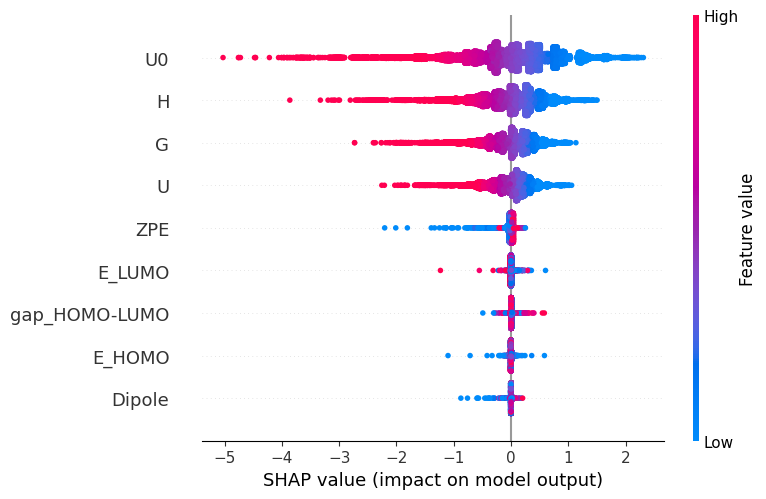

In [28]:
shap.summary_plot(shap_values, X_test)

O gráfico acima é um SHAP *summary plot*, uma forma de visualizar a importância e o efeito das variáveis em um modelo preditivo.  

Cada ponto representa uma observação (amostra do conjunto de dados), e sua posição no eixo horizontal indica o impacto da *feature* no *output* do modelo — isto é, o quanto aquela variável contribuiu para aumentar ou diminuir a predição.

Cada ponto representa uma amostra, com a cor indicando o valor da *feature* (rosa = alto, azul = baixo).

**Análise geral**

- **Eixo X (SHAP *value*)**: mostra o quanto cada *feature* contribui para aumentar (valores positivos) ou diminuir (valores negativos) a predição do modelo.
- **Eixo Y (*features*)**: ordena as variáveis por importância média (impacto absoluto dos valores SHAP).
- **Cores**: representam o valor real da *feature* — tons quentes (rosa/vermelho) indicam valores altos, e tons frios (azul) indicam valores baixos.

**Interpretação Detalhada**

1. `U0`, `H`, `G` e `U`
- Essas quatro variáveis concentram a maior parte do poder explicativo do modelo XGBoost, com clara hierarquia de importância liderada por U0, seguida de H, G e U.
- Observa-se ampla dispersão dos valores SHAP, indicando que essas features modulam significativamente a predição ao longo de diferentes regimes do espaço de dados.
- O padrão cromático é consistente: valores elevados dessas grandezas (tons rosados) estão predominantemente associados a contribuições negativas para a saída do modelo, enquanto valores baixos (tons azulados) contribuem positivamente.
- Isso caracteriza uma relação inversa robusta entre energias termodinâmicas globais e a variável alvo: aumentos em energia interna, entalpia, energia de Gibbs ou energia de referência tendem a reduzir a predição, ao passo que reduções nessas quantidades a elevam.
- A assimetria e a largura das distribuições refletem a capacidade do XGBoost de capturar não linearidades e interações condicionais, indo além de um efeito médio global e ajustando respostas distintas conforme a região do espaço de features.

2. `ZPE`
- Apresenta impacto secundário, com valores SHAP concentrados em torno de zero e baixa dispersão.
- Há leve variação local, mas sem padrão direcional claro ou influência sistemática sobre a predição.
- Isso sugere que a energia de ponto zero não atua como fator determinante isolado no modelo, podendo ter efeito apenas residual ou indireto via correlação com outras variáveis energéticas.

3. `E_LUMO`, `gap_HOMO–LUMO`, `E_HOMO` e `Dipole`
- As propriedades eletrônicas exibem impacto marginal, com distribuições SHAP fortemente centradas em zero e praticamente simétricas.
- Mesmo em valores extremos das features, a contribuição para a saída do modelo permanece pequena, indicando ausência de efeito preditivo relevante.
- Não se observa relação monotônica nem padrão de interação forte capturado pelo XGBoost, reforçando a ideia de irrelevância estrutural dessas variáveis para a tarefa específica.

O XGBoost fundamenta suas previsões quase exclusivamente em variáveis termodinâmicas globais (`U0`, `H`, `G` e `U`), explorando relações não lineares e efeitos condicionais entre elas. Propriedades eletrônicas — como energias orbitais, gap HOMO–LUMO e momento dipolar — desempenham papel claramente residual, não contribuindo de forma significativa para a explicação das predições.

***Insight* científico**

A dominância ainda mais acentuada de `U0` no XGBoost, em comparação a modelos mais lineares, sugere que o algoritmo capturou um mecanismo energético central associado à estabilidade ou ao balanço termodinâmico do sistema, explorando regiões específicas do espaço de dados onde pequenas variações nessas energias produzem efeitos preditivos relevantes. A irrelevância das variáveis eletrônicas indica que, no domínio amostrado, os efeitos microscópicos da estrutura eletrônica são de segunda ordem ou já estão efetivamente incorporados nas grandezas termodinâmicas globais, reforçando a coerência física do modelo e a adequação do XGBoost para aprender relações energéticas dominantes de natureza macroscópica.

As indicações apresentadas pelo SHAP podem ser confirmadas por meio de uma nova previsão, mas somente com as *features* que o SHAP apresenta como as mais relevantes.

In [34]:
best_model.fit(X_train[['U0', 'H', 'G', 'U']], y_train)

y_pred = best_model.predict(X_test[['U0', 'H', 'G', 'U']])
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE do melhor modelo: {rmse}')

RMSE do melhor modelo: 0.14547316811796374


### *Bar plot*

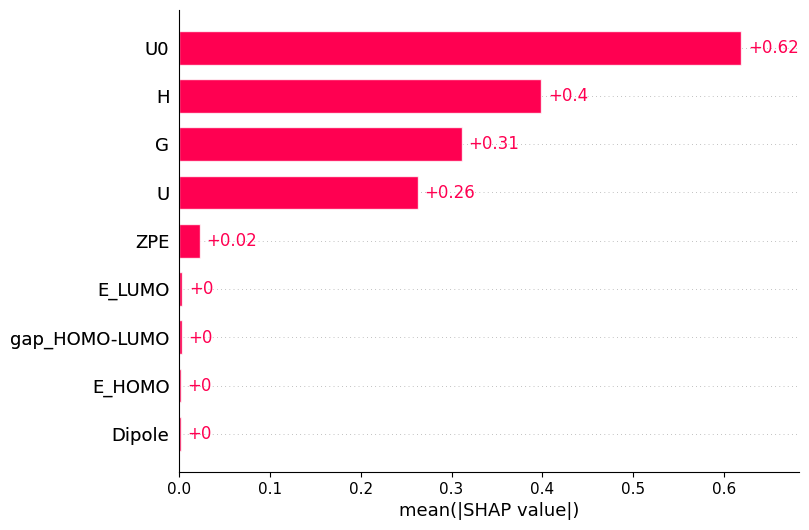

In [29]:
shap_values_exp = shap.Explanation(
    values=shap_values,        # passa o array direto
    data=X_test,               # seu DataFrame de teste
    feature_names=X_test.columns
)

shap.plots.bar(shap_values_exp)

O gráfico acima mostra a importância média das variáveis no modelo, calculada pela média dos valores absolutos de SHAP (`mean(|SHAP value|)`).  
Ele representa, em termos quantitativos, o quanto cada *feature* contribui em média para as variações das previsões.

`Estrutura do gráfico`
- **Eixo X:** magnitude média dos valores SHAP — quanto maior, maior o impacto da *feature* no resultado.  
- **Eixo Y:** lista das *features* avaliadas.  
- **Cor e anotação à direita:** indicam o valor numérico do impacto médio.

**Interpretação Detalhada**

1. `U0`, `H`, `G` e `U`

- O *bar plot* confirma, de forma quantitativa e agregada, a forte concentração do poder explicativo do modelo nessas quatro variáveis termodinâmicas globais.
- `U0` destaca-se de maneira dominante, com o maior valor médio absoluto de SHAP $(\approx 0.62)$, indicando que variações nessa feature produzem, em média, os maiores deslocamentos na predição do modelo.
- `H` $(\approx 0.40)$, `G` $(\approx 0.31)$ e `U` $(\approx 0.26)$ aparecem na sequência, compondo um núcleo informacional coerente, no qual cada variável contribui de forma relevante e complementar para a decisão do XGBoost.
- A diferença de magnitude entre `U0` e as demais sugere que o modelo utiliza essa variável como referência energética central, a partir da qual os demais termos ajustam a predição em regime local.

2. `ZPE`
- Apresenta contribuição média muito reduzida $(\approx 0.02)$, situando-se em um regime limítrofe entre relevância estatística e ruído.
- Embora não seja completamente ignorada pelo modelo, sua influência global é desprezível quando comparada às energias termodinâmicas principais, indicando papel apenas residual.

3. `E_LUMO`, `gap_HOMO–LUMO`, `E_HOMO` e `Dipole`
- Essas variáveis exibem valores médios absolutos de SHAP praticamente nulos, evidenciando ausência de contribuição preditiva global.
- O XGBoost, portanto, não depende dessas propriedades eletrônicas para construir suas previsões, mesmo considerando possíveis interações não lineares.


O *bar plot* de $\mathrm{mean}(|\mathrm{SHAP}|)$ revela uma estrutura explicativa altamente concentrada, na qual praticamente toda a variância explicada pelo XGBoost é atribuída a quatro grandezas energéticas macroscópicas. As demais *features* não participam de forma significativa do processo decisório, nem mesmo como moduladores secundários.

***Insight* científico**

A supremacia de `U0`, seguida por `H`, `G` e `U`, indica que o XGBoost internalizou um eixo energético dominante, compatível com um mecanismo físico governado por balanço e estabilidade termodinâmica. A anulação prática das contribuições de propriedades eletrônicas sugere que, no domínio de dados considerado, os efeitos microscópicos associados à estrutura eletrônica são irrelevantes para o alvo ou já estão implicitamente codificados nas energias globais. Esse resultado reforça não apenas a coerência física do modelo, mas também sua parcimônia efetiva: apesar da alta flexibilidade, o XGBoost converge para uma representação explicativa simples e alinhada com princípios termodinâmicos fundamentais.

### *Waterfall plot*

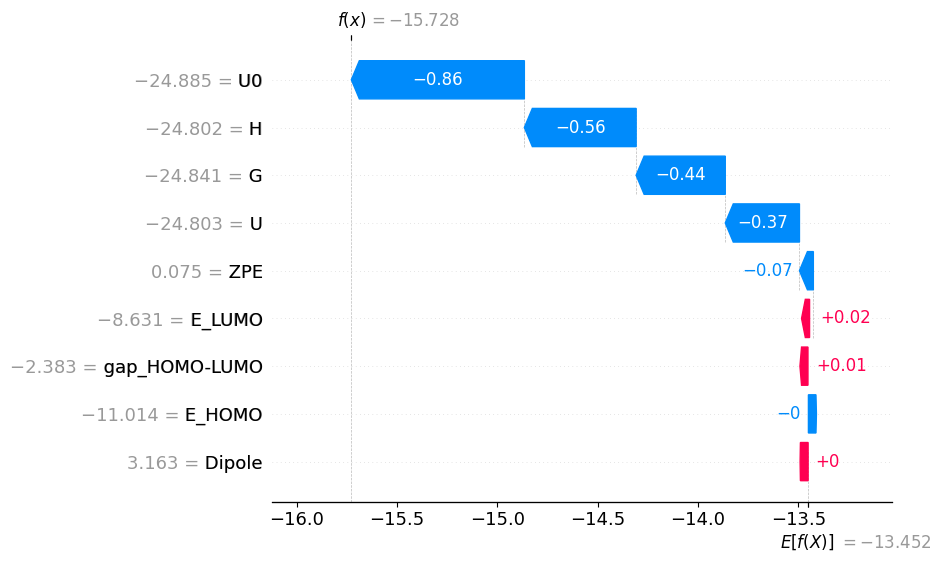

In [30]:
# Base value manual
base_value = best_model.predict(X_train).mean()  # média das previsões no conjunto de treino

# Cria o objeto Explanation
shap_values_exp = shap.Explanation(
    values=shap_values,        # array de SHAP
    base_values=base_value,    # agora passa o valor base
    data=X_test,
    feature_names=X_test.columns
)

# Agora funciona no waterfall
shap.plots.waterfall(shap_values_exp[1])

O *waterfall plot* apresenta a decomposição da predição do modelo para uma instância específica, evidenciando como cada *feature* desloca o valor esperado do modelo $\mathbb{E}[f(X)] \approx −13.45$ até a predição final $f(x) \approx −15.73.$

1. `U0`, `H`, `G` e `U`
- As quatro variáveis termodinâmicas globais são responsáveis pela quase totalidade do deslocamento negativo da predição em relação ao valor médio.
- `U0` exerce a maior influência individual, com contribuição SHAP de aproximadamente −0.86, atuando como principal vetor de redução da saída do modelo.
- Em seguida, `H` $(−0.56)$, `G` $(−0.44)$ e `U` $(−0.37)$ reforçam esse movimento, compondo um efeito cumulativo coerente e monotônico.
- Os valores observados dessas *features* (todas próximas de $−24.8$) situam-se em um regime que o modelo associa sistematicamente a reduções na predição, em plena concordância com o padrão global identificado no *summary plot*.

2. `ZPE`
- Apresenta contribuição pequena e negativa (≈ −0.07), atuando apenas como ajuste fino local.
- Seu efeito não altera qualitativamente a decisão do modelo, mas contribui marginalmente para o deslocamento final.

3. `E_LUMO`, `gap_HOMO–LUMO`, `E_HOMO` e `Dipole`
- Essas *features* exibem contribuições extremamente pequenas, algumas levemente positivas (+0.01 a +0.02) e outras praticamente nulas.
- Seus efeitos são insuficientes para compensar o impacto negativo dominante das variáveis energéticas globais, confirmando sua irrelevância prática para esta instância.


A predição específica é essencialmente determinada por um acúmulo de contribuições negativas provenientes das energias termodinâmicas globais, que empurram a saída do modelo para valores significativamente abaixo da média. As demais variáveis atuam apenas como correções residuais, sem influência decisiva.

***Insight* científico**

A coerência entre explicação local (*waterfall*) e explicações globais (*summary* e *bar plot*) indica que o XGBoost não depende de regras idiossincráticas para casos individuais, mas aplica de forma consistente um princípio energético dominante: configurações caracterizadas por energias internas, entalpias e energias livres mais elevadas conduzem sistematicamente a predições menores. Essa consistência sugere que o modelo internalizou um mecanismo físico estável e generalizável, reforçando a interpretabilidade científica e a robustez do aprendizado realizado.

# Conclusão

A análise integrada do desempenho preditivo do XGBoost e das explicações fornecidas pelos diferentes gráficos de SHAP permite estabelecer uma conclusão simultaneamente estatística, algorítmica e físico-científica sobre o modelo induzido.

Do ponto de vista quantitativo, o modelo otimizado via `optuna` apresenta desempenho elevado, com $(\mathrm{RMSE} \approx 0.095)$ durante a validação e $(\mathrm{RMSE} \approx 0.011)$ no teste final. Apesar da diferença absoluta entre essas métricas, ambas permanecem na mesma ordem de grandeza, indicando boa capacidade de generalização e ausência de degradação severa fora do regime de ajuste. O conjunto de hiperparâmetros selecionado — caracterizado por *learning rate* baixo, número elevado de estimadores, profundidade moderada e regularização extremamente suave — revela uma estratégia de aprendizado progressiva e refinada, na qual o modelo constrói a função de regressão por meio de ajustes incrementais e altamente localizados, explorando não linearidades sem recorrer a penalizações excessivas.

Sob a perspectiva explicativa, os gráficos de SHAP (*summary plot, bar plot e waterfall plot*) convergem de forma inequívoca para um mesmo resultado: o comportamento do modelo é dominado quase exclusivamente pelas variáveis termodinâmicas globais `U0`, `H`, `G` e `U`. Essas *features* concentram praticamente toda a massa explicativa global $(\mathrm{mean} (|\mathrm{SHAP}|))$, exibem relações monotônicas bem definidas com a saída do modelo e, em nível local, respondem pela quase totalidade do deslocamento da predição em relação ao valor esperado. Em contraste, propriedades eletrônicas como `E_HOMO`, `E_LUMO`, `gap_ HOMO–LUMO` e `Dipole` apresentam contribuições desprezíveis, tanto global quanto localmente, atuando apenas como correções residuais ou sendo efetivamente ignoradas pelo algoritmo.

Essa coerência entre explicações globais e locais indica que o XGBoost não opera por meio de regras espúrias ou dependentes de casos isolados, mas internaliza um mecanismo explicativo estável, no qual a predição é governada por um eixo energético macroscópico bem definido. A relação inversa observada — energias termodinâmicas mais elevadas conduzindo sistematicamente a valores menores da variável alvo — sugere que o modelo capturou uma regularidade física fundamental associada a estabilidade, balanço energético ou custo termodinâmico do sistema analisado.

O experimento adicional, no qual o modelo foi treinado exclusivamente com as *features* `H`, `G`, `U` e `U0`, reforça essa interpretação. Embora o $\mathrm{RMSE}$ aumente para $\approx 0.145$, o desempenho permanece competitivo e da mesma ordem de grandeza, evidenciando que essas quatro variáveis concentram o núcleo causal-informacional do problema. A diferença de desempenho em relação ao modelo completo indica que as demais *features* não são totalmente irrelevantes, mas atuam apenas como moduladores secundários, refinando a predição sem alterar sua estrutura fundamental.

Em síntese, o XGBoost induzido combina alto desempenho preditivo, parcimônia efetiva e consistência físico-conceitual. Apesar de sua elevada flexibilidade, o modelo converge para uma representação explicativa simples, ancorada em grandezas termodinâmicas globais, o que não apenas reforça sua robustez estatística, mas também confere legitimidade científica ao mecanismo aprendido. Trata-se, portanto, de um modelo que não apenas prediz bem, mas o faz de maneira alinhada com princípios físicos plausíveis e interpretáveis.

# Referências

[1] Izbicki and dos Santos - 2020 - Aprendizado de máquina.pdf

[2] CHEN, T.; GUESTRIN, C. XGBoost: Model Structure. 2023. Disponível em: https://xgboost.readthedocs.io/en/stable/tutorials/model.html. Acesso em: 03 de nov. de 2025.

[3] IBM. XGBoost: conceitos e aplicações. IBM Think Topics, 2023. Disponível em: https://www.ibm.com/br-pt/think/topics/xgboost. Acesso em: 03 de nov. de 2025.

[4] LIGEIRO, Gabriel. Como interpretar seu modelo de machine learning usando SHAP values. Medium, 5 dez. 2020. Disponível em: https://gabrielligeiro.medium.com/como-interpretar-seu-modelo-de-machine-learning-usando-shap-values-2c61c0d26317. Acesso em: 24 out. 2025.

[5] LUNDBERG, Scott; LEE, Su-In. SHAP – Welcome to the SHAP documentation. 2018. Disponível em: https://shap.readthedocs.io/en/latest/. Acesso em: 24 out. 2025.

[6] AWAN, Abid Ali. Uma introdução aos valores SHAP e à interpretabilidade do aprendizado de máquina. DataCamp, 11 set. 2024. Disponível em: https://www.datacamp.com/pt/tutorial/introduction-to-shap-values-machine-learning-interpretability. Acesso em: 24 out. 2025.